In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import os.path as op
import glob
import matplotlib.pyplot as plt
import ast
# import moss
import csv
import random
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from matplotlib.ticker import PercentFormatter
from statsmodels.stats.anova import AnovaRM
from sklearn.preprocessing import StandardScaler
from matplotlib.cm import get_cmap
from plot_utils import combined_rolling_average_and_model_fit, combined_sliding_window_and_model_fit_split_col
from common_functions import remove_unit_variance
scaler = StandardScaler()

df = pd.read_csv('pilot_total.csv')
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df_cleaned = pd.read_csv('pilot_total_errors.csv')

df_cond = pd.read_csv('resources/conditions_file_1.csv')

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_35777/892982536.py:29: DtypeWarning: Columns (254,255,256,257,258,259) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('pilot_total.csv')
/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_35777/892982536.py:31: DtypeWarning: Columns (157,254,255,256,257,258,259) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cleaned = pd.read_csv('pilot_total_errors.csv')


In [3]:
df['pilot_number']

0        1
1        1
2        1
3        1
4        1
        ..
80632    2
80633    2
80634    2
80635    2
80636    2
Name: pilot_number, Length: 80637, dtype: int64

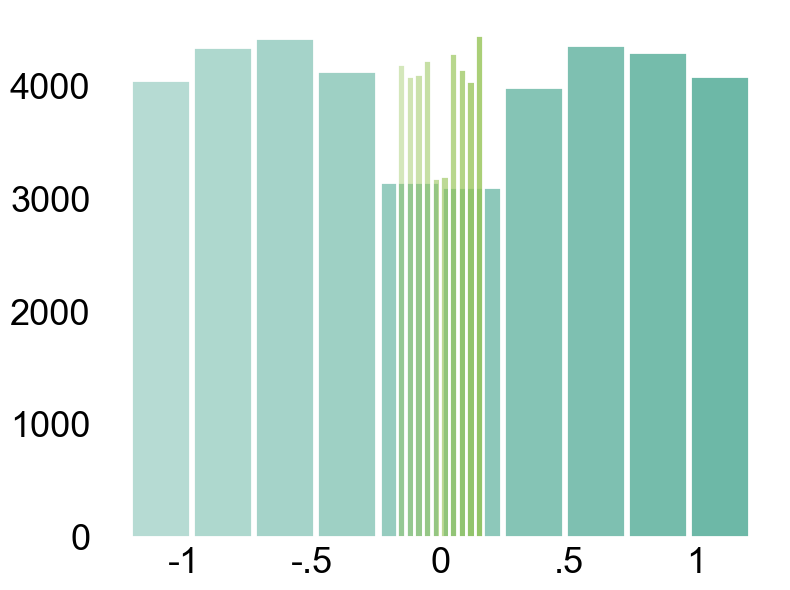

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

def remove_leading_zero_formatter(x, pos):
    """Remove leading zero and trailing zeros from decimal numbers on axis ticks"""
    if x == 0:
        return '0'
    elif -1 < x < 1:
        # Format and remove trailing zeros, then leading zero
        formatted = f'{x:.3f}'.rstrip('0').rstrip('.')
        if formatted.startswith('0.'):
            formatted = formatted[1:]  # Remove leading zero
        elif formatted.startswith('-0.'):
            formatted = '-' + formatted[2:]  # Remove leading zero but keep minus
        return formatted
    else:
        # For numbers >= 1 or <= -1, remove trailing zeros
        return f'{x:.3f}'.rstrip('0').rstrip('.')

def create_gradient_colormap(base_color, n_colors=14):
    """Create a gradient colormap from light to dark based on a base color"""
    # Convert hex to RGB
    base_rgb = tuple(int(base_color.lstrip('#')[i:i+2], 16)/255 for i in (0, 2, 4))
    
    # Create lighter and darker versions
    colors = []
    for i in range(n_colors):
        # Gradient from lighter (0.4 opacity) to darker (0.8 opacity)
        alpha = 0.4 + (0.4 * i / (n_colors - 1))
        colors.append((*base_rgb, alpha))
    
    return colors
# "Tested - Untested IT Distractor Similarity"
# "Tested - Untested V2 Distractor Similarity"
def plot_similarity_distributions(df, pilot_number=None, it_col="Tested - Untested IT Distractor Similarity", 
                                v2_col="Tested - Untested V2 Distractor Similarity",
                                pilot_col="pilot_number", bins=14, figsize=(8, 6), 
                                plot_type='both'):
   
    teal = '#49a791'  # IT color
    green = '#95c355'  # V2 color
    
    # Create single plot
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Filter data for specific pilot or use full dataframe
    if pilot_number is not None:
        plot_data = df[df[pilot_col] == pilot_number]
        if len(plot_data) == 0:
            print(f"No data found for pilot {pilot_number}")
            return
    else:
        plot_data = df
    
    # Create gradient colors
    teal_gradient = create_gradient_colormap(teal, bins)
    green_gradient = create_gradient_colormap(green, bins)
    
    # Plot IT histogram with gradient
    if plot_type in ['it', 'both']:
        it_data = plot_data[it_col].dropna()
        counts, bin_edges = np.histogram(it_data, bins=bins)
        bin_width = bin_edges[1] - bin_edges[0]
        
        # Draw bars with gradient colors
        for i, (count, edge) in enumerate(zip(counts, bin_edges[:-1])):
            ax.bar(edge + bin_width/2, count, width=bin_width*0.95, 
                   color=teal_gradient[i], edgecolor='white', linewidth=2)
        
        # Add KDE
        # from scipy import stats
        # kde = stats.gaussian_kde(it_data)
        # x_range = np.linspace(it_data.min(), it_data.max(), 200)
        # kde_values = kde(x_range)
        # # Scale KDE to match histogram height
        # kde_scaled = kde_values * len(it_data) * bin_width
        # ax.plot(x_range, kde_scaled, color=teal, linewidth=2, alpha=0.8)
    
    # Plot V2 histogram with gradient
    if plot_type in ['v2', 'both']:
        v2_data = plot_data[v2_col].dropna()
        counts, bin_edges = np.histogram(v2_data, bins=bins)
        bin_width = bin_edges[1] - bin_edges[0]
        
        # Draw bars with gradient colors
        for i, (count, edge) in enumerate(zip(counts, bin_edges[:-1])):
            ax.bar(edge + bin_width/2, count, width=bin_width*0.95, 
                   color=green_gradient[i], edgecolor='white', linewidth=2)
        
        # Add KDE
        # from scipy import stats
        # kde = stats.gaussian_kde(v2_data)
        # x_range = np.linspace(v2_data.min(), v2_data.max(), 200)
        # kde_values = kde(x_range)
        # # Scale KDE to match histogram height
        # kde_scaled = kde_values * len(v2_data) * bin_width
        # ax.plot(x_range, kde_scaled, color=green, linewidth=2, alpha=0.8)
   
    # Remove plot borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Set background color
    ax.set_facecolor('white')
    
    # Style ticks with no labels
    ax.tick_params(axis='x', colors='black', labelsize=26, labelcolor='black',
                  bottom=False, top=False, labelbottom=True)
    ax.tick_params(axis='y', colors='black', labelsize=26, labelcolor='black',
                  left=False, right=False, labelleft=True)
    
    # Remove leading/trailing zeros from x-axis
    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    # Set font family for tick labels
    for label in ax.get_xticklabels():
        label.set_fontfamily('Arial')
    for label in ax.get_yticklabels():
        label.set_fontfamily('Arial')
    
    # Remove grid and all labels
    ax.grid(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_similarity_distributions(df, pilot_number=1)                    # Both histograms overlaid
# plot_similarity_distributions(df, plot_type='it')  # Only IT histogram
# plot_similarity_distributions(df, plot_type='v2')  # Only V2 histogram
plot_similarity_distributions(df, bins = 10, pilot_number=1, plot_type='both')                # Full dataframe, both histograms



In [59]:
df['IT Distractor Similarity to Tested Item

SyntaxError: EOL while scanning string literal (4008349033.py, line 1)

<Axes: xlabel='IT_im2_minus_im1', ylabel='Count'>

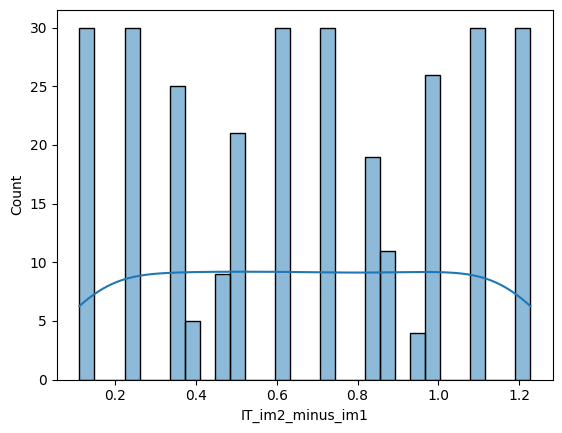

In [46]:
#plot_similarity_distributions(df, pilot_number=1, it_col = 'IT Distractor Similarity to Tested Item', v2_col='V2 Distractor Similarity to Tested Item')
sns.histplot(data = df_cond, x = "IT_im2_minus_im1", kde = True, bins = 30)


# plt.hist(df["Tested - Untested V2 Distractor Similarity"])



<Axes: xlabel='IT_im2_minus_im1', ylabel='Count'>

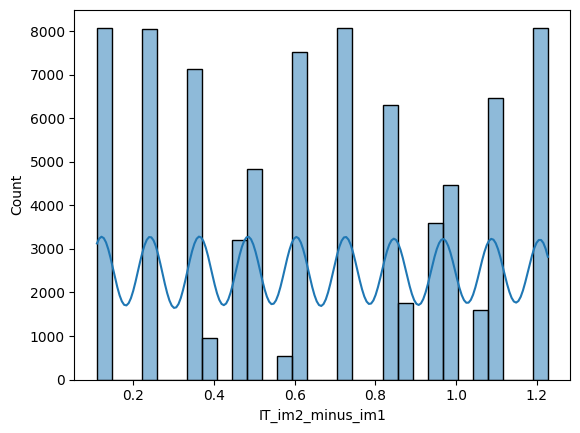

In [47]:
sns.histplot(data = df, x = "IT_im2_minus_im1", kde = True, bins = 30)


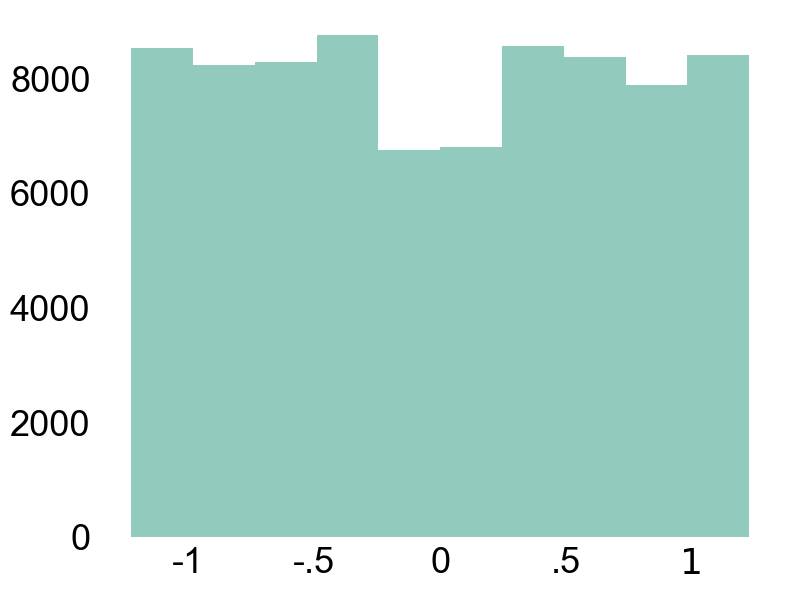

In [86]:


def plot_similarity_distributions(df, pilot_number=None, it_col="Tested - Untested IT Distractor Similarity", 
                                v2_col="Tested - Untested V2 Distractor Similarity",
                                pilot_col="pilot_number", bins=14, figsize=(8, 6), 
                                plot_type='both'):
   
    teal = '#49a791'
    green = '#95c355'
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    if pilot_number is not None:
        plot_data = df[df[pilot_col] == pilot_number]
        if len(plot_data) == 0:
            print(f"No data found for pilot {pilot_number}")
            return
    else:
        plot_data = df
    
    
    if plot_type in ['it', 'both']:
        sns.histplot(data=plot_data, x=it_col, bins=bins, kde=False,
                    color=teal, alpha=0.6, edgecolor='white', linewidth=0, ax=ax, element = 'step')
    
    if plot_type in ['v2', 'both']:
        sns.histplot(data=plot_data, x=v2_col, bins=bins, kde=False, 
                    color=green, alpha=0.6, edgecolor='white', linewidth=0, ax=ax, element = 'step')
    
    # Styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_facecolor('white')
    
    ax.tick_params(axis='x', colors='black', labelsize=26, labelcolor='black',
                  bottom=False, top=False, labelbottom=True)
    ax.tick_params(axis='y', colors='black', labelsize=26, labelcolor='black',
                  left=False, right=False, labelleft=True)
    
    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontfamily('Arial')
    
    ax.grid(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
    
    plt.tight_layout()
    plt.show()

plot_similarity_distributions(df, bins = 10,  plot_type = 'it')



In [78]:
df['pilot_col']

KeyError: 'pilot_col'

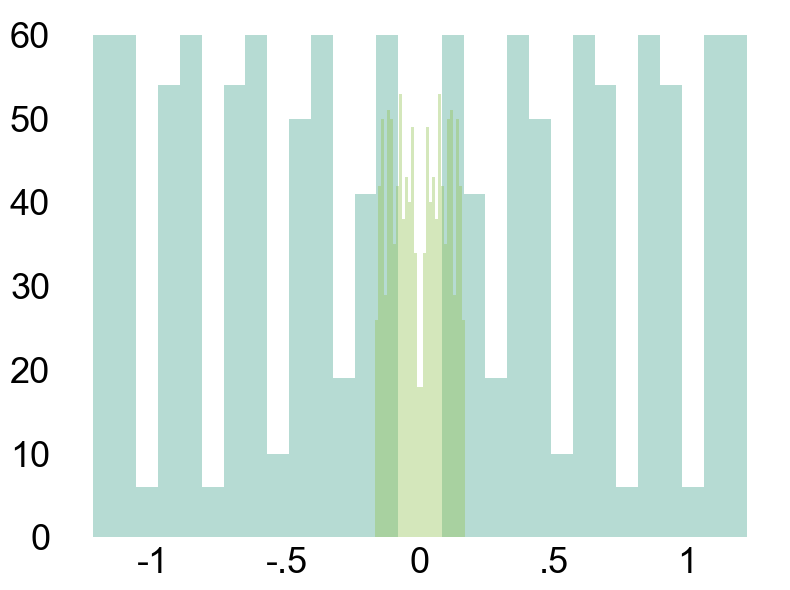

In [57]:
plot_similarity_distributions(df, pilot_number=2)


In [78]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter

def remove_leading_zero_formatter(x, pos):
    """Remove leading zero and trailing zeros from decimal numbers on axis ticks"""
    if x == 0:
        return '0'
    elif -1 < x < 1:
        # Format and remove trailing zeros, then leading zero
        formatted = f'{x:.3f}'.rstrip('0').rstrip('.')
        if formatted.startswith('0.'):
            formatted = formatted[1:]  # Remove leading zero
        elif formatted.startswith('-0.'):
            formatted = '-' + formatted[2:]  # Remove leading zero but keep minus
        return formatted
    else:
        # For numbers >= 1 or <= -1, remove trailing zeros
        return f'{x:.3f}'.rstrip('0').rstrip('.')

def plot_similarity_distributions_gradient(df, pilot_number=None, it_col="Tested - Untested IT Distractor Similarity", 
                                         v2_col="Tested - Untested V2 Distractor Similarity",
                                         pilot_col="pilot_number", bins=30, figsize=(10, 6)):
    """
    Plot histograms with gradient colors mirrored around 0. 
    Shows either one specific pilot or all data combined.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the data
    pilot_number : int, str, or None
        Specific pilot number to plot. If None, shows all data combined.
    it_col : str
        Column name for IT distractor similarity
    v2_col : str
        Column name for V2 distractor similarity  
    pilot_col : str
        Column name for pilot/batch identifier
    bins : int
        Number of bins for histograms
    figsize : tuple
        Figure size (width, height)
    """
    
    # Colors for gradients
    teal = '#49a791'  # IT color
    green = '#95c355'  # V2 color
    
    # Create single plot
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Filter data based on pilot selection
    if pilot_number is not None:
        # Single pilot
        plot_data = df[df[pilot_col] == pilot_number]
        if len(plot_data) == 0:
            print(f"No data found for pilot {pilot_number}")
            return
        title_info = f"Pilot {pilot_number}"
    else:
        # All data combined
        plot_data = df
        title_info = "All Data Combined"
    
    # Get UNIQUE similarity values
    it_similarities = plot_data[it_col].dropna().unique()
    v2_similarities = plot_data[v2_col].dropna().unique()
    
    # Create histograms to get bin edges and counts
    it_counts, it_edges = np.histogram(it_similarities, bins=bins)
    v2_counts, v2_edges = np.histogram(v2_similarities, bins=bins)
    
    # Calculate overall max distance for consistent gradient scaling
    all_similarities = np.concatenate([it_similarities, v2_similarities])
    max_distance = max(abs(all_similarities.min()), abs(all_similarities.max())) if len(all_similarities) > 0 else 1
    
    # Plot IT similarities with gradient based on distance from 0
    for j in range(len(it_counts)):
        if it_counts[j] > 0:
            bin_center = (it_edges[j] + it_edges[j+1]) / 2
            distance_from_zero = abs(bin_center)
            
            # Normalize distance for color intensity (closer to 0 = lighter)
            if max_distance > 0:
                intensity = distance_from_zero / max_distance
            else:
                intensity = 0
            
            # Create gradient alpha based on distance from zero
            alpha = 0.25 + 0.65 * intensity  # Range from 0.25 to 0.9
            
            ax.bar(bin_center, it_counts[j], 
                  width=(it_edges[j+1] - it_edges[j]), 
                  color=teal, alpha=alpha, edgecolor='none')
    
    # Plot V2 similarities with gradient
    for j in range(len(v2_counts)):
        if v2_counts[j] > 0:
            bin_center = (v2_edges[j] + v2_edges[j+1]) / 2
            distance_from_zero = abs(bin_center)
            
            # Normalize distance for color intensity using same scale
            if max_distance > 0:
                intensity = distance_from_zero / max_distance
            else:
                intensity = 0
            
            # Create gradient alpha based on distance from zero
            alpha = 0.25 + 0.65 * intensity  # Range from 0.25 to 0.9
            
            ax.bar(bin_center, v2_counts[j], 
                  width=(v2_edges[j+1] - v2_edges[j]), 
                  color=green, alpha=alpha, edgecolor='none')
    
    # Add vertical line at x=0
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.6, linewidth=2)
    
    # Style the axis
    spine_color = '#B8B8B8'
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_color(spine_color)
    ax.spines['left'].set_color(spine_color)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    
    # Set background color
    ax.set_facecolor('white')
    
    # Style ticks
    ax.tick_params(axis='x', colors=spine_color, labelsize=26, labelcolor='black',
                  bottom=True, top=False, labelbottom=True)
    ax.tick_params(axis='y', colors=spine_color, labelsize=26, labelcolor='black',
                  left=True, right=False, labelleft=True)
    
    # Remove leading/trailing zeros from x-axis
    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    # Set font family for tick labels
    for label in ax.get_xticklabels():
        label.set_fontfamily('Arial')
    for label in ax.get_yticklabels():
        label.set_fontfamily('Arial')
    
    # Remove grid and labels
    ax.grid(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
    
    plt.tight_layout()
    plt.show()
    

# Example usage:

# View just one pilot with gradients:
# plot_similarity_distributions_gradient(df, pilot_number=1)
# plot_similarity_distributions_gradient(df, pilot_number=2)



# plot_similarity_distributions_gradient(df)

    

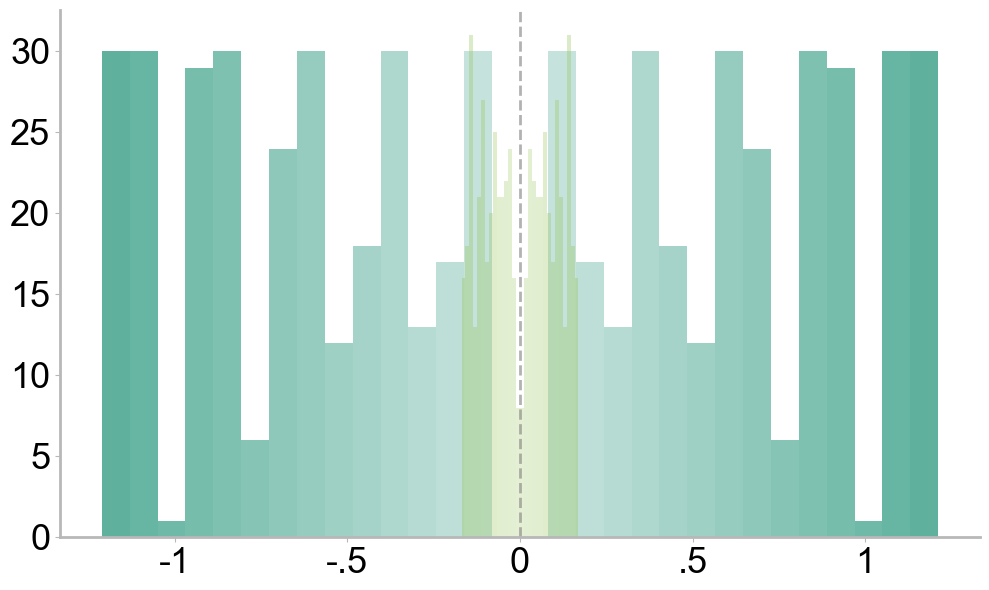

In [79]:
plot_similarity_distributions_gradient(df, pilot_number=1)




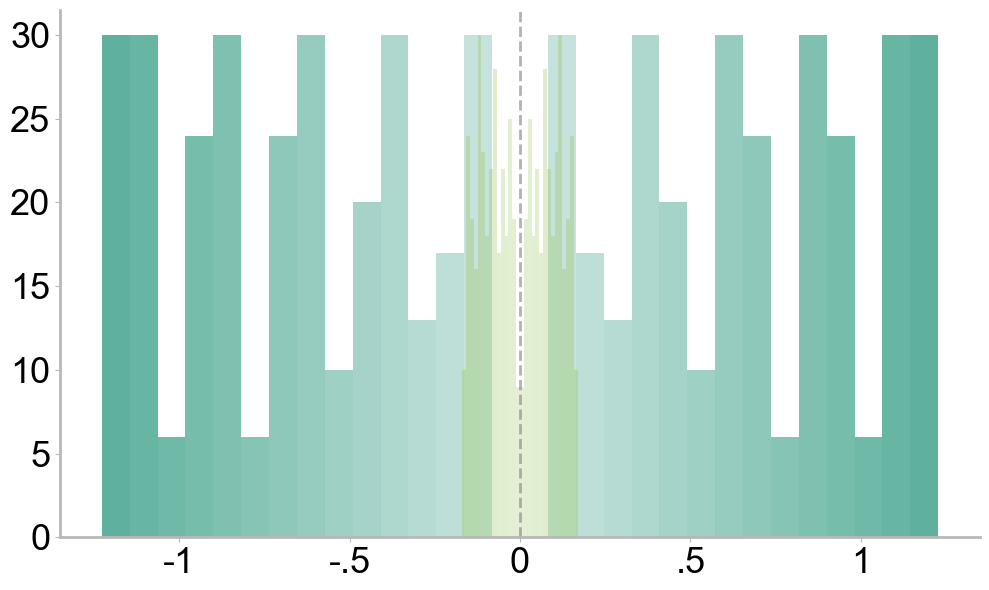

In [83]:
plot_similarity_distributions_gradient(df, pilot_number=2)


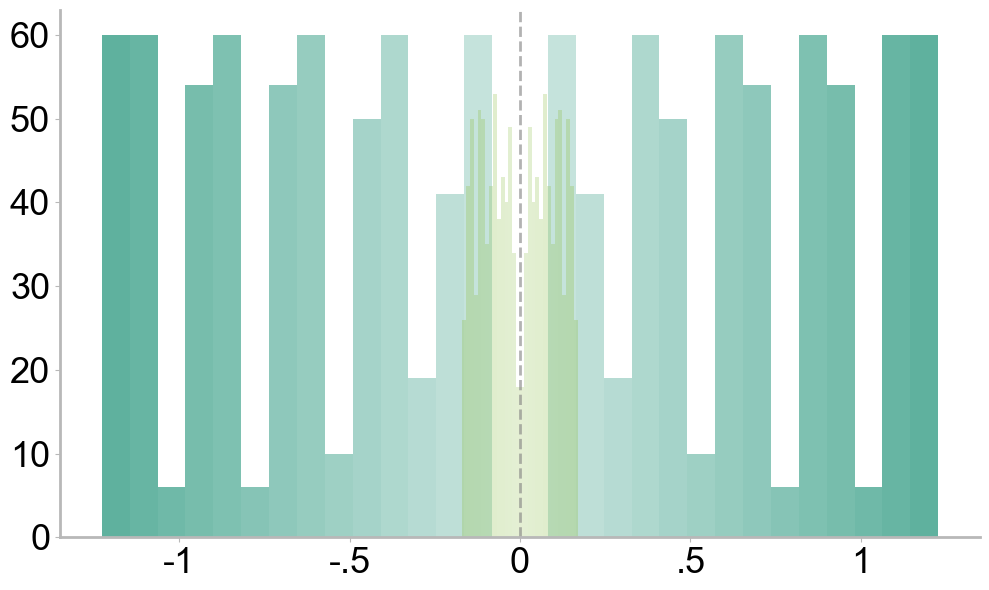

In [84]:
plot_similarity_distributions_gradient(df)


In [85]:
df = pd.read_csv('df_ltm_testing_pilot_total.csv')


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_35755/4148758435.py:1: DtypeWarning: Columns (156) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('df_ltm_testing_pilot_total.csv')


In [87]:
df_foils = df[df['Attend'] == 'foil']

In [97]:
cols = df_foils.columns
for c in cols:
    print(c)

Unnamed: 0.1
setup_js.started
setup_js.stopped
participant
date
expName
psychopyVersion
OS
frameRate
Instructions1.started
Instructions1.stopped
key_resp_2.keys
key_resp_2.rt
key_resp_2.duration
Instructions2.started
Instructions2.stopped
key_resp_3.keys
key_resp_3.rt
key_resp_3.duration
Instructions3.started
Instructions3.stopped
key_resp_4.keys
key_resp_4.rt
key_resp_4.duration
Instructions4.started
Instructions4.stopped
key_resp_5.keys
key_resp_5.rt
key_resp_5.duration
Instructions5.started
Instructions5.stopped
key_resp_10.keys
key_resp_10.rt
key_resp_10.duration
Instructions6b.started
Instructions6b.stopped
key_resp_16.keys
key_resp_16.rt
key_resp_16.duration
Instructions6.started
Instructions6.stopped
key_resp_13.keys
key_resp_13.rt
key_resp_13.duration
memoranda.started
memoranda.stopped
isi1.started
isi1.stopped
probe.started
probe.stopped
mouse.x
mouse.y
mouse.leftButton
mouse.midButton
mouse.rightButton
mouse.time
mouse.clicked_name
resp_correct
taskPhase
correct_ans.started


In [104]:
df_foils['wm_category_num'].unique()

KeyError: 'wm_category_num'